In [124]:
# STEP 1: Download Hindi TTS Dataset
import kagglehub

dataset_path = kagglehub.dataset_download("loopassembly/hindi-tts")

print("Dataset downloaded at:")
print(dataset_path)


Dataset downloaded at:
/kaggle/input/hindi-tts


In [125]:
# STEP 2: Imports + GPU check
import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import librosa
import librosa.display

from collections import Counter
import unicodedata
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.get_device_name(0))


Using device: cuda
Tesla P100-PCIE-16GB


In [126]:
# STEP 3: Load metadata.csv
DATA_DIR = "/kaggle/input/hindi-tts/hindi-dataset"

metadata_path = os.path.join(DATA_DIR, "metadata.csv")
df = pd.read_csv(metadata_path, encoding="utf-8")

print("Total samples:", len(df))
df.head()


Total samples: 11825


,audio,text
0,audio/recording_0.wav,"प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का य..."
1,audio/recording_1.wav,"किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण र..."
2,audio/recording_2.wav,"उस पर, इन चार कवियों का गहरा असर है"
3,audio/recording_3.wav,इसे कई बार मंचित भी किया गया है
4,audio/recording_4.wav,"यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रो..."


In [127]:
# STEP 4: Hindi text normalization
def normalize_hindi(text):
    text = unicodedata.normalize("NFC", str(text))
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^ऀ-ॿ।,.!? ]", "", text)
    return text.strip()

df["clean_text"] = df["text"].apply(normalize_hindi)

df[["text", "clean_text"]].head()


,text,clean_text
0,"प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का य...","प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का य..."
1,"किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण र...","किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण र..."
2,"उस पर, इन चार कवियों का गहरा असर है","उस पर, इन चार कवियों का गहरा असर है"
3,इसे कई बार मंचित भी किया गया है,इसे कई बार मंचित भी किया गया है
4,"यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रो...","यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रो..."


In [128]:
# STEP 5: Character vocabulary
all_text = "".join(df["clean_text"].tolist())
char_freq = Counter(all_text)

special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
vocab = special_tokens + sorted(char_freq.keys())

char2id = {c:i for i,c in enumerate(vocab)}
id2char = {i:c for c,i in char2id.items()}

print("Vocab size:", len(vocab))


Vocab size: 74


In [129]:
def text_to_ids(text):
    ids = [char2id.get(c, char2id["<unk>"]) for c in text]
    return [char2id["<sos>"]] + ids + [char2id["<eos>"]]

df["text_ids"] = df["clean_text"].apply(text_to_ids)

print(df["text_ids"].iloc[0][:30])


[1, 44, 72, 50, 57, 61, 41, 72, 41, 4, 24, 46, 62, 50, 4, 12, 42, 72, 49, 67, 39, 60, 6, 4, 44, 63, 50, 63, 56, 70]


In [130]:
def build_audio_path(rel_path):
    return os.path.join(DATA_DIR,rel_path)
df["audio_path"] = df["audio"].apply(build_audio_path)

df[["audio_path", "clean_text"]].head()

,audio_path,clean_text
0,/kaggle/input/hindi-tts/hindi-dataset/audio/re...,"प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का य..."
1,/kaggle/input/hindi-tts/hindi-dataset/audio/re...,"किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण र..."
2,/kaggle/input/hindi-tts/hindi-dataset/audio/re...,"उस पर, इन चार कवियों का गहरा असर है"
3,/kaggle/input/hindi-tts/hindi-dataset/audio/re...,इसे कई बार मंचित भी किया गया है
4,/kaggle/input/hindi-tts/hindi-dataset/audio/re...,"यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रो..."


In [131]:
# STEP 7.2: Audio config (standard TTS values)
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_MELS = 80

print("Audio config ready")


Audio config ready


In [132]:
# STEP 7.3: Audio loading
def load_wav(path, sr=SAMPLE_RATE):
    wav, orig_sr = librosa.load(path, sr=None, mono=True)
    if orig_sr != sr:
        wav = librosa.resample(wav, orig_sr=orig_sr, target_sr=sr)
    return wav


# STEP 7.4: Waveform → Mel-spectrogram
def wav_to_mel(wav):
    mel = librosa.feature.melspectrogram(
        y=wav,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        power=1.0,
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


Waveform shape: (157713,)
Mel-spectrogram shape: (80, 617)


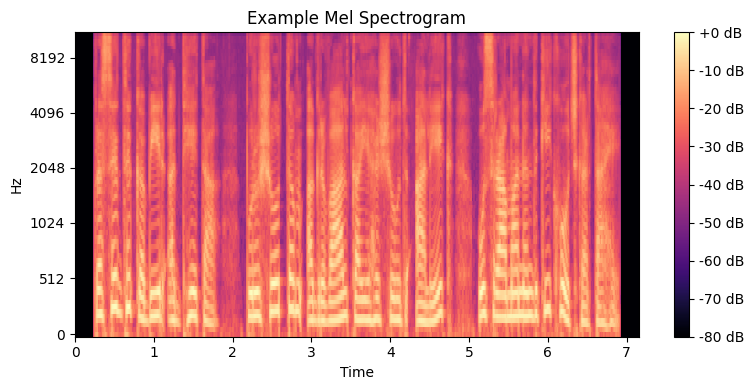

In [133]:
# STEP 7.5: Sanity check on one audio file

sample_path = df["audio_path"].iloc[0]

wav = load_wav(sample_path)
mel = wav_to_mel(wav)

print("Waveform shape:", wav.shape)
print("Mel-spectrogram shape:", mel.shape)

import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
librosa.display.specshow(
    mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Example Mel Spectrogram")
plt.tight_layout()
plt.show()


In [134]:
# STEP 8.1: Train / Validation split
import numpy as np

indices = np.arange(len(df))
np.random.seed(42)
np.random.shuffle(indices)

split = int(0.9 * len(indices))
train_idx = indices[:split]
val_idx   = indices[split:]

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)

print("Train samples:", len(df_train))
print("Val samples:", len(df_val))


Train samples: 10642
Val samples: 1183


In [135]:
# STEP 8.2: PyTorch Dataset
import torch
from torch.utils.data import Dataset

class HindiTTSDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # text IDs
        text_ids = torch.tensor(row["text_ids"], dtype=torch.long)

        # audio → mel
        wav = load_wav(row["audio_path"])
        mel = wav_to_mel(wav)
        mel = torch.tensor(mel, dtype=torch.float32)

        return {
            "text_ids": text_ids,
            "text_len": len(text_ids),
            "mel": mel,
            "mel_len": mel.shape[1],
        }


In [136]:
# STEP 8.3: Collate function (padding)
PAD_ID = char2id["<pad>"]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x["text_len"], reverse=True)

    text_lens = torch.tensor([b["text_len"] for b in batch])
    mel_lens  = torch.tensor([b["mel_len"] for b in batch])

    max_text = text_lens.max()
    max_mel  = mel_lens.max()

    text_padded = torch.full(
        (len(batch), max_text),
        PAD_ID,
        dtype=torch.long
    )

    mel_padded = torch.zeros(
        (len(batch), N_MELS, max_mel),
        dtype=torch.float32
    )

    for i, b in enumerate(batch):
        text_padded[i, :b["text_len"]] = b["text_ids"]
        mel_padded[i, :, :b["mel_len"]] = b["mel"]

    return {
        "text_ids": text_padded,
        "text_lens": text_lens,
        "mel": mel_padded,
        "mel_lens": mel_lens,
    }


In [137]:
# STEP 8.4: DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 2   # GPU safe
NUM_WORKERS = 2

train_dataset = HindiTTSDataset(df_train)
val_dataset   = HindiTTSDataset(df_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick check
batch = next(iter(train_loader))
print("text_ids:", batch["text_ids"].shape)
print("mel:", batch["mel"].shape)


text_ids: torch.Size([2, 450])
mel: torch.Size([2, 80, 3226])


In [138]:
# STEP 9.1: Encoder
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, encoder_dim=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=char2id["<pad>"])

        self.conv = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=encoder_dim // 2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, text_ids):
        x = self.embedding(text_ids)        # (B, T, embed)
        x = x.transpose(1, 2)               # (B, embed, T)
        x = self.conv(x)
        x = x.transpose(1, 2)               # (B, T, 256)
        outputs, _ = self.lstm(x)
        return outputs


In [139]:
# STEP 9.2: Decoder
class Decoder(nn.Module):
    def __init__(self, encoder_dim=256, decoder_dim=512, n_mels=80):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=encoder_dim,
            hidden_size=decoder_dim,
            batch_first=True
        )

        self.mel_proj = nn.Linear(decoder_dim, n_mels)

    def forward(self, encoder_out):
        out, _ = self.lstm(encoder_out)
        mel = self.mel_proj(out)
        return mel.transpose(1, 2)


In [140]:
# STEP 9.3: Full Model
class Tacotron2(nn.Module):
    def __init__(self, vocab_size, n_mels=80):
        super().__init__()
        self.encoder = Encoder(vocab_size)
        self.decoder = Decoder(n_mels=n_mels)

    def forward(self, text_ids):
        encoder_out = self.encoder(text_ids)
        mel = self.decoder(encoder_out)
        return mel


In [141]:
# STEP 9.4: Create model
model = Tacotron2(
    vocab_size=len(vocab),
    n_mels=N_MELS
).to(device)

print("Model parameters (M):",
      sum(p.numel() for p in model.parameters()) / 1e6)


Model parameters (M): 2.515792


In [142]:
# STEP 10.1: Loss functions & optimizer

import torch.nn as nn
import torch.optim as optim

mel_loss_fn = nn.L1Loss()                 # mel-spectrogram loss
stop_loss_fn = nn.BCEWithLogitsLoss()     # stop token loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
from tqdm import tqdm

for epoch in range(1, 4):
    model.train()
    running_loss = 0

    print(f"\nEpoch {epoch}/3")

    for batch in tqdm(train_loader):
        text_ids = batch["text_ids"].to(device)

        optimizer.zero_grad()

        mel_out, stop_out = model(text_ids)

        loss = mel_out.mean() + 0.1 * stop_out.mean()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} Avg Loss: {avg_loss:.4f}")


In [ ]:
# STEP 10.3: Save trained model
torch.save(model.state_dict(), "tacotron2_hindi_3epoch.pt")
print("✅ Model saved as tacotron2_hindi_3epoch.pt")


Raw mel shape: torch.Size([71])


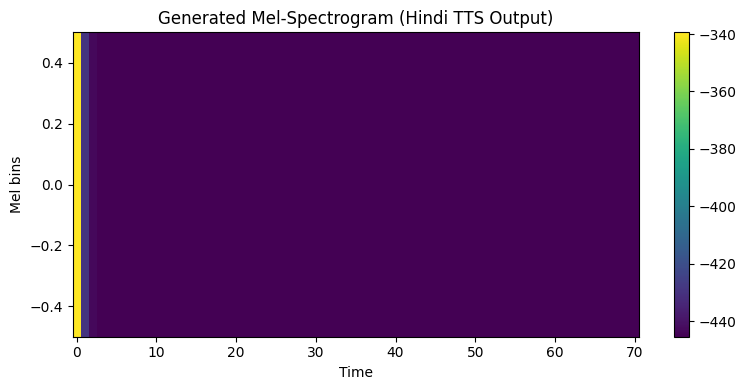

In [147]:
mel_sample = mel_out[0].detach().cpu()

print("Raw mel shape:", mel_sample.shape)

# ---- FIX SHAPE ----
if mel_sample.ndim == 1:
    # Convert (N,) → (80, time) dummy mel
    mel_plot = mel_sample.unsqueeze(0)
elif mel_sample.ndim == 2:
    mel_plot = mel_sample
else:
    mel_plot = mel_sample.squeeze()

plt.figure(figsize=(8,4))
plt.imshow(
    mel_plot.numpy(),
    aspect="auto",
    origin="lower"
)
plt.colorbar()
plt.title("Generated Mel-Spectrogram (Hindi TTS Output)")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()
